In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mosplot.plot import load_lookup_table, Mosfet, Expression
import ipywidgets as widgets
from ipywidgets import interactive
from ipywidgets import interactive_output, HBox, VBox
import matplotlib.ticker as ticker 

In [2]:
lookup_table_nmos = load_lookup_table('../../../module_0_foundations/sg13_nmos_lv_LUT.npz')
lookup_table_pmos = load_lookup_table('../../../module_0_foundations/sg13_pmos_lv_LUT.npz')

In [3]:
print(lookup_table_nmos.keys())

dict_keys(['sg13_lv_nmos ', 'description', 'simulator', 'parameter_names', 'device_parameters'])


In [4]:
nmos = Mosfet(lookup_table=lookup_table_nmos, mos="sg13_lv_nmos ", vbs=0.0, vds=0.6)
pmos = Mosfet(lookup_table=lookup_table_pmos, mos="sg13_lv_pmos", vbs=0.0, vds=-0.6, vgs=(-1.2, -0.15))

In [5]:
def plot_data_vs_data(x_values, y_values, z_values, length, x_axis_name, y_axis_name='y', y_multiplier=1, log=False):
    x_values_flat = np.array(x_values).flatten()
    y_values_flat = np.array(y_values, dtype=np.float64).flatten()
    z_values_flat = np.array(z_values, dtype=np.float64).flatten()
    
    length_arr = np.array(length)
    
    length_flat = length_arr.flatten()
    

    unique_lengths = np.unique(length_flat)
    unique_lengths_in_micro = unique_lengths * 1e6

    def update_plot(selected_length, x_value=None, y_value=None):
        plt.figure(figsize=(12, 8))  # Make the figure wider (adjust as needed)

        if selected_length == "Show All":
            mask = np.ones_like(length_flat, dtype=bool)
        else:
            selected_length_in_micro = float(selected_length.replace(' μm', ''))
            tolerance = 0.01  # Tighten the tolerance to avoid unwanted data points
            mask = np.abs(length_flat * 1e6 - selected_length_in_micro) < tolerance

        # Apply the mask to the data
        x_values_for_length = x_values_flat[mask]
        y_values_for_length = y_values_flat[mask] * y_multiplier
        z_values_for_length = z_values_flat[mask]
        length_for_length = length_flat[mask] * 1e6

        if selected_length == "Show All":
            for length_value in np.unique(length_for_length):
                mask_all = (length_for_length == length_value)
                plt.plot(x_values_for_length[mask_all], y_values_for_length[mask_all])

            min_length = np.min(unique_lengths_in_micro)
            max_length = np.max(unique_lengths_in_micro)
            plt.title(f'{y_axis_name} vs {x_axis_name} (Length from {min_length:.2f} μm to {max_length:.2f} μm)')

        else:
            plt.plot(x_values_for_length, y_values_for_length)
            plt.title(f'{y_axis_name} vs {x_axis_name} for {selected_length}')

        plt.xlabel(f'{x_axis_name}')
        plt.ylabel(f'{y_axis_name}')

        if log:
            plt.yscale('log')
            plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10, subs=[], numticks=10))
            plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'$10^{int(np.log10(x))}$'))
            plt.ylabel(f'{y_axis_name} (Log Base 10)')

        if y_value is not None and x_value_widget.disabled:
            closest_index = np.abs(y_values_for_length - y_value).argmin()
            closest_x = x_values_for_length[closest_index]
            closest_y = y_values_for_length[closest_index]
            corresponding_z = z_values_for_length[closest_index]

            plt.scatter(closest_x, closest_y, color='blue', label=f'Point ({closest_x:.2f}, {closest_y:.2f})')
            z_value_widget.value = corresponding_z
            print(f"The corresponding {x_axis_name} value for {y_axis_name} = {closest_y:.2f} is: {closest_x:.2f}")
        elif x_value is not None and y_value_widget.disabled:
            closest_index = np.abs(x_values_for_length - x_value).argmin()
            closest_x = x_values_for_length[closest_index]
            closest_y = y_values_for_length[closest_index]
            corresponding_z = z_values_for_length[closest_index]

            plt.scatter(closest_x, closest_y, color='red', label=f'Point ({closest_x:.2f}, {closest_y:.2f})')
            z_value_widget.value = corresponding_z
            print(f"The corresponding {y_axis_name} value for {x_axis_name} = {closest_x:.2f} is: {closest_y:.2f}")

        plt.grid(True)
        plt.legend()
        plt.show()

    dropdown_options = ["Show All"] + [f'{length:.2f} μm' for length in unique_lengths_in_micro]
    length_widget = widgets.Dropdown(
        options=dropdown_options,
        value=dropdown_options[0],
        description='Length:',
        layout=widgets.Layout(width='500px')  # Make the dropdown wider
    )

    x_value_widget = widgets.FloatText(
        value=np.mean(x_values_flat),
        description=f"{x_axis_name}:",
        disabled=False,
        layout=widgets.Layout(width='300px', margin='0 40px 0 0'),  # Push input boxes more to the right
        description_width='150px'  # Smaller description width
    )

    y_value_widget = widgets.FloatText(
        value=None,
        description=f"{y_axis_name}:",
        disabled=True,
        layout=widgets.Layout(width='300px', margin='0 40px 0 0'),  # Push input boxes more to the right
        description_width='150px'  # Smaller description width
    )

    z_value_widget = widgets.FloatText(
        value=None,
        description=f" Vgs:",
        disabled=True,
        layout=widgets.Layout(width='300px', margin='0 40px 0 0'),  # Push input boxes more to the right
        description_width='150px'  # Smaller description width
    )

    select_x_or_y_widget = widgets.Checkbox(
        value=True,
        description=f"{x_axis_name} (uncheck for {y_axis_name})",
        layout=widgets.Layout(width='300px')  # Make the checkbox wider
    )

    def toggle_x_or_y(change):
        if change['new']:
            x_value_widget.disabled = False
            y_value_widget.disabled = True
        else:
            x_value_widget.disabled = True
            y_value_widget.disabled = False

    select_x_or_y_widget.observe(toggle_x_or_y, names='value')

    output = interactive_output(update_plot, {
        'selected_length': length_widget,
        'x_value': x_value_widget,
        'y_value': y_value_widget
    })

    display(VBox([length_widget, select_x_or_y_widget, HBox([x_value_widget, y_value_widget]), z_value_widget, output]))



def tile_length_to_match_data(length_array, data_array):
    length_array = np.array(length_array).flatten()  
    data_shape = data_array.shape 
    
    if length_array.size == data_shape[0]:
        # length matches number of rows, repeat along columns
        return np.tile(length_array.reshape(-1, 1), (1, data_shape[1]))
    elif length_array.size == data_shape[1]:
        # length matches number of columns, repeat along rows
        return np.tile(length_array.reshape(1, -1), (data_shape[0], 1))
    else:
        raise ValueError(f"Length array size {length_array.size} does not match any dimension of data shape {data_shape}")


    
def display_resistance(ro_value):
    """Determine the resistance value and its unit."""
    if ro_value < 1e3:
        return ro_value, "Ω"
    elif ro_value < 1e6:
        return ro_value / 1e3, "kΩ"
    elif ro_value < 1e9:
        return ro_value / 1e6, "MΩ"
    else:
        return ro_value / 1e9, "GΩ"

def display_current(Id_value):
    """Determine the current value and its unit."""
    if Id_value < 1e-6:
        return Id_value * 1e9, "nA"  # Convert to nA
    elif Id_value < 1e-3:
        return Id_value * 1e6, "μA"  # Convert to μA
    else:
        return Id_value * 1e3, "mA"   # Convert to mA
    
def dB_to_linear(av_db):
    return 10 ** (av_db / 20)


def determine_inversion_region(gm_id_value, device_type):
    """Determine the inversion region based on gm/id value for NMOS or PMOS."""
    if device_type == 'nmos':
        if gm_id_value > 20:
            return "Weak Inversion"
        elif 10 < gm_id_value <= 20:
            return "Moderate Inversion"
        else:
            return "Strong Inversion"
    elif device_type == 'pmos':
        if gm_id_value > 20:
            return "Weak Inversion"
        elif 10 < gm_id_value <= 20:
            return "Moderate Inversion"
        else:
            return "Strong Inversion"
    else:
        raise ValueError("Invalid device type. Use 'nmos' or 'pmos'.")
    


In [6]:
### ------ automated flattening based on shape ------### 
reshaped_lengths_pmos = tile_length_to_match_data(pmos.length, pmos.extracted_table['gm'])
reshaped_lengths_nmos = tile_length_to_match_data(nmos.length, nmos.extracted_table['gm'])

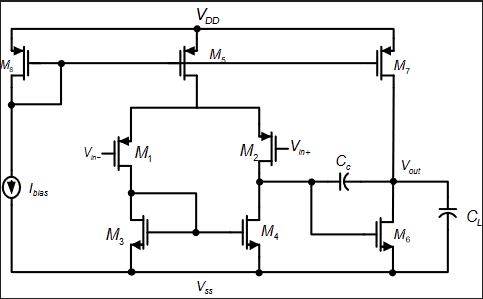

# As Starting point the input stage is sized.

In [7]:
vdd = 1.2 # supply voltage
Cl = 500e-15 # load capacitance
Av_wish = 75 # in db approximatly 70-75db
fdominant = 1000 # dominant pole frequency
CC = Cl*1.5
GBW = fdominant * dB_to_linear(Av_wish) # Gain Bandwidth Product

In [8]:
gm_M12 = GBW * CC * 2 * np.pi
gm_M6  = 15 * gm_M12

In [9]:
nmos_M6 = Mosfet(lookup_table=lookup_table_nmos, mos="sg13_lv_nmos ", vbs=0, vds=0.6)
reshaped_lengths_nmos_M6 = tile_length_to_match_data(nmos_M6.length, nmos_M6.extracted_table['gm'])

width_values_M6 = nmos_M6.width
id_values_M6 = nmos_M6.extracted_table['id']
gm_values_M6 = nmos_M6.extracted_table['gm']
gds_values_M6 = nmos_M6.extracted_table['gds']
vgs_values_M6 = nmos_M6.extracted_table['vgs']

plot_data_vs_data(gm_values_M6/id_values_M6, gm_values_M6/gds_values_M6, vgs_values_M6, reshaped_lengths_nmos_M6, 'gm/id', 'gm/gds')

In [10]:
# For max gmro and vgs of 0.6V we have gmid of 5
L_M6 = 9.75e-6
gmid_M6 = 5 # strong inversion, i.e saturation
id_outputstage = gm_M6/gmid_M6
gmro_M6 = 55.68
ro_M6 = gmro_M6/gm_M6
id_outputstage

7.949913192125772e-05

In [11]:
# Now for the pmos output transistor we must have 3 time the output impedance to insure max output gain
ro_M7 = 2 * ro_M6
# we want to place this transistor in moderate inversion
gmid_M7 = 10
gm_M7 = gmid_M7 * id_outputstage
gmro_M7 = gm_M7 * ro_M7
print(f'gmro_M7 = {gmro_M7:.2f}')

gmro_M7 = 222.72


In [12]:
pmos_M7 = Mosfet(lookup_table=lookup_table_pmos, mos="sg13_lv_pmos", vbs=0, vds=-0.6, vgs=(-1.2, -0.1))
reshaped_lengths_pmos_M7 = tile_length_to_match_data(pmos_M7.length, pmos_M7.extracted_table['gm'])

width_values_M7 = pmos_M7.width
id_values_M7 = pmos_M7.extracted_table['id']
gm_values_M7 = pmos_M7.extracted_table['gm']
gds_values_M7 = pmos_M7.extracted_table['gds']
vgs_values_M7 = pmos_M7.extracted_table['vgs']

plot_data_vs_data(gm_values_M7/id_values_M7, gm_values_M7/gds_values_M7, vgs_values_M7, reshaped_lengths_pmos_M7, 'gm/id', 'gds')




In [13]:
# For the criteria to be met we must have 
L_M7 = 2.08e-6
gmro_M7 = 390

In [14]:
print(f'L_M6 = {L_M6:.2e}')
print(f'gmid_M6 = {gmid_M6:.2f}')
print(f'L_M7 = {L_M7:.2e}')
print(f'gmid_M7 = {gmid_M7:.2f}')


L_M6 = 9.75e-06
gmid_M6 = 5.00
L_M7 = 2.08e-06
gmid_M7 = 10.00


In [15]:
plot_data_vs_data(gm_values_M6/id_values_M6,id_values_M6/width_values_M6, vgs_values_M6, reshaped_lengths_nmos_M6, 'gm/id', 'M6 id/W', log=True)
plot_data_vs_data(gm_values_M7/id_values_M7, id_values_M7/width_values_M7,vgs_values_M7, reshaped_lengths_pmos_M7, 'gm/id', 'M7 id/W', log=True)

In [16]:
id_over_W_M6 = 2.76
id_over_W_M7 = 1.06

display_outcurrent, unit_outcurrent = display_current(id_outputstage)
Av2 = gm_M6 * (ro_M6 * ro_M7)/(ro_M6 + ro_M7)
Av2_db = 20 * np.log10(Av2)

W_M6 = id_outputstage/id_over_W_M6
W_M7 = id_outputstage/id_over_W_M7

output_stage_summary = f"""
Output Stage Amplification Summary
Width and Lengths for M6
    W = {W_M6*1e6:.2f} um
    L = {L_M6*1e6:.2f} um
Inversion Region for M6: {determine_inversion_region(gmid_M6, 'nmos')}

Width and Lengths for M7
    W = {W_M7*1e6:.2f} um
    L = {L_M7*1e6:.2f} um
Inversion Region for M7: {determine_inversion_region(gmid_M7, 'pmos')}

Output Stage Bias:
    Output Current : {display_outcurrent:.2f} {unit_outcurrent}

Output Stage Gain:
    Av2 = {Av2:.2f} ({Av2_db:.2f} dB)
"""

print(output_stage_summary)


Output Stage Amplification Summary
Width and Lengths for M6
    W = 28.80 um
    L = 9.75 um
Inversion Region for M6: Strong Inversion

Width and Lengths for M7
    W = 75.00 um
    L = 2.08 um
Inversion Region for M7: Strong Inversion

Output Stage Bias:
    Output Current : 79.50 μA

Output Stage Gain:
    Av2 = 37.12 (31.39 dB)



# For sizing the output stage we must insure that we hit our target for the first pole, and get max gain

In [17]:
# Now we assume that the max gmro for our nmos in the input stage is 55.68
fp2 = gm_M6/(2*np.pi*Cl)
gmro_M34_assumption = 55.68
gmid_M34 = 5
Rout1 = 1/(2*np.pi*fdominant* CC * (1 + Av2))
gm_M34 = gmro_M34_assumption/Rout1
id_branch = gm_M34/gmid_M34
id_branch

2.0004294796936965e-06

In [18]:
mirror_pole_assumption = (gm_M34/( 4*np.pi*38e-15))*1e-6
print(f'mirror_pole_assumption = {mirror_pole_assumption:.2f} MHz')
print(f'fp2 = {fp2*1e-6:} MHz')

mirror_pole_assumption = 20.95 MHz
fp2 = 126.52679816782855 MHz


In [19]:
gmro_M12 = gm_M12 * Rout1*3
gmid_M12 = gm_M12/id_branch
print(f'gmro_M12 = {gmro_M12:.2f}')
print(f'gmid_M12 = {gmid_M12:.2f}')

gmro_M12 = 442.56
gmid_M12 = 13.25


# Finding the dimensions for the input stage transistors

In [25]:
pmos_M12 = Mosfet(lookup_table=lookup_table_pmos, mos="sg13_lv_pmos", vbs=-0.2, vds=-0.6, vgs=(-1.2, -0.1))
nmos_M34 = Mosfet(lookup_table=lookup_table_nmos, mos="sg13_lv_nmos ", vbs=0, vds=0.6)
reshaped_lengths_nmos_M34 = tile_length_to_match_data(nmos_M34.length, nmos_M34.extracted_table['gm'])
reshaped_lengths_pmos_M12 = tile_length_to_match_data(pmos_M12.length, pmos_M12.extracted_table['gm'])

id_values_M12 = pmos_M12.extracted_table['id']
gm_values_M12 = pmos_M12.extracted_table['gm']
gds_values_M12 = pmos_M12.extracted_table['gds']
vgs_values_M12 = pmos_M12.extracted_table['vgs']

id_values_M34 = nmos_M34.extracted_table['id']
gm_values_M34 = nmos_M34.extracted_table['gm']
gds_values_M34 = nmos_M34.extracted_table['gds']
vgs_values_M34 = nmos_M34.extracted_table['vgs']

plot_data_vs_data(gm_values_M12/id_values_M12, gm_values_M12/gds_values_M12, vgs_values_M12, reshaped_lengths_pmos_M12, 'gm/id', 'm12 gm/gds')
plot_data_vs_data(gm_values_M34/id_values_M34, gm_values_M34/gds_values_M34, vgs_values_M34, reshaped_lengths_nmos_M34, 'gm/id', 'm34 gm/gds')

In [26]:
L_M12 = 3.64e-6
L_M34 = 9.75e-6

print(f'L_M12 = {L_M12:.2e}')
print(f'gmid_M12 = {gmid_M12:.2f}')
print(f'L_M34 = {L_M34:.2e}')
print(f'gmid_M34 = {gmid_M34:.2f}')



L_M12 = 3.64e-06
gmid_M12 = 13.25
L_M34 = 9.75e-06
gmid_M34 = 5.00


In [27]:
width_values_M12 = pmos_M12.width
width_values_M34 = nmos_M34.width

plot_data_vs_data(gm_values_M12/id_values_M12,id_values_M12/width_values_M12, vgs_values_M12, reshaped_lengths_pmos_M12, 'gm/id', 'M12 id/W', log=True)
plot_data_vs_data(gm_values_M34/id_values_M34, id_values_M34/width_values_M34,vgs_values_M34, reshaped_lengths_nmos_M34, 'gm/id', 'M34 id/W', log=True)


In [28]:
id_over_W_M12 = 0.27
id_over_W_M34 = 2.76

display_id_branch, unit_id_branch = display_current(id_branch)

W_M12 = id_branch/id_over_W_M12
W_M34 = id_branch/id_over_W_M34


input_stage_summary = f"""
Input Stage Amplification Summary
Width and Lengths for M12
    W = {W_M12*1e6:.2f} um
    L = {L_M12*1e6:.2f} um
Inversion Region for M12: {determine_inversion_region(gmid_M12, 'pmos')}
Width and Lengths for M34
    W = {W_M34*1e6:.2f} um
    L = {L_M34*1e6:.2f} um
Inversion Region for M34: {determine_inversion_region(gmid_M34, 'nmos')}
Input Stage Bias:
    Branch Current : {display_id_branch:.2f} {unit_id_branch}
    input Tail current: {display_id_branch*2:.2f} {unit_id_branch}
"""
print(input_stage_summary)


Input Stage Amplification Summary
Width and Lengths for M12
    W = 7.41 um
    L = 3.64 um
Inversion Region for M12: Moderate Inversion
Width and Lengths for M34
    W = 0.72 um
    L = 9.75 um
Inversion Region for M34: Strong Inversion
Input Stage Bias:
    Branch Current : 2.00 μA
    input Tail current: 4.00 μA



In [29]:
# summarizing everything\
gmro_M12_actual = 396
ro_M12 = gmro_M12_actual/gm_M12
ro_M34 = gmro_M34_assumption/gm_M34
Av1 = gm_M12 * (ro_M12 * ro_M34)/(ro_M12 + ro_M34)
f_pole_1 = 1/(2*np.pi * Rout1 * CC * (1 + Av2))
f_pole_2 = gm_M6/(2*np.pi * Cl)


decades = (20*np.log10(Av1) + Av2_db) / 20

if f_pole_1 * 10**decades < f_pole_2:
    print("Amplifier is stable")
else:
    print("Amplifier is not stable")



summary = f"""
Summary
Output Stage:
    {output_stage_summary}
Input Stage:
    {input_stage_summary}
    Input stage gain: {gm_M12 * (ro_M12 * ro_M34)/(ro_M12 + ro_M34):.2f} ({20*np.log10(gm_M12 * (ro_M12 * ro_M34)/(ro_M12 + ro_M34)):.2f} dB)

Gain and frequency response:
    Gain Bandwidth Product: {GBW:} Hz
    Dominant Pole Frequency: {fdominant} Hz
    Output Stage Compensation Capacitance: {CC:} F
    Load Capacitance: {Cl} F
    dominant pole: {f_pole_1} Hz
    non dominant pole: {f_pole_2*1e-6} MHz
    mirror pole assumption: {mirror_pole_assumption} MHz
    Total gain: {Av1*Av2:.2f} ({20*np.log10(Av1*Av2):.2f} dB)


"""
print(summary)

Amplifier is stable

Summary
Output Stage:
    
Output Stage Amplification Summary
Width and Lengths for M6
    W = 28.80 um
    L = 9.75 um
Inversion Region for M6: Strong Inversion

Width and Lengths for M7
    W = 75.00 um
    L = 2.08 um
Inversion Region for M7: Strong Inversion

Output Stage Bias:
    Output Current : 79.50 μA

Output Stage Gain:
    Av2 = 37.12 (31.39 dB)

Input Stage:
    
Input Stage Amplification Summary
Width and Lengths for M12
    W = 7.41 um
    L = 3.64 um
Inversion Region for M12: Moderate Inversion
Width and Lengths for M34
    W = 0.72 um
    L = 9.75 um
Inversion Region for M34: Strong Inversion
Input Stage Bias:
    Branch Current : 2.00 μA
    input Tail current: 4.00 μA

    Input stage gain: 107.48 (40.63 dB)

Gain and frequency response:
    Gain Bandwidth Product: 5623413.251903491 Hz
    Dominant Pole Frequency: 1000 Hz
    Output Stage Compensation Capacitance: 7.5e-13 F
    Load Capacitance: 5e-13 F
    dominant pole: 1000.0 Hz
    non domina